In [9]:
import sys
print(sys.version)
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_USE_LEGACY_KERAS'] = "1"
!pip install torch torch_geometric


3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [37]:
import datetime
import copy
import torch
from torch.utils.data import TensorDataset
import logging
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from bs4 import BeautifulSoup
#import xml.etree.ElementTree as Xet
from argparse import ArgumentParser
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss
from sklearn.preprocessing import MinMaxScaler
#from nbeats_pytorch.model import NBeatsNet
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm



In [11]:
class DataLoader:
    """
    Load data into desired formats for training/validation/testing, including preprocessing.
    """

    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.scaler = list()
        self.historical_values = list()  # first by patient idx, then by col_idx

    def preprocessing(
        self,
        lst_train_arrays,
        lst_test_arrays,
        # train_mode=True, # flag for train_mode (split into train/val), test_mode (no split)
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
        train_arrays = copy.deepcopy(lst_train_arrays)
        test_arrays = copy.deepcopy(lst_test_arrays)
        # count valid timesteps for each individual series
        # train_array.shape = n_timesteps x n_features
        self.valid_steps_train = [train_array.shape[0] for train_array in train_arrays]
        train_lst, val_lst, test_lst = list(), list(), list()
        for idx in range(len(train_arrays)):
            #print(idx, "index")
            bg_sample_train = train_arrays[idx]
            #bg_sample_train_exog = np.delete(train_arrays[idx], 0, 1)
            bg_sample_test = test_arrays[idx]#[:, target_col]
            #bg_sample_test_exog = np.delete(test_arrays[idx], 0, 1)
            valid_steps_sample = self.valid_steps_train[idx]
            #train_target = bg_sample_train_target[: int(train_size * valid_steps_sample)].copy()
            train = bg_sample_train[: int(train_size * valid_steps_sample), :].copy()
            #val_target = bg_sample_train_target[int(train_size * valid_steps_sample) :].copy()
            val = bg_sample_train[int(train_size * valid_steps_sample) :, :].copy()
            #test_target = bg_sample_test_target[:].copy()
            test = bg_sample_test[:, :].copy()
            if self.normalize:
                scaler_cols = list()
                # train.shape = n_train_timesteps x n_features
                for col_idx in range(train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform((add_extra_dim(train[:, col_idx])))
                    )
                    val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(val[:, col_idx]))
                    )
                    test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(test[:, col_idx]))
                    )
                    scaler_cols.append(scaler)  # by col_idx, each feature
                self.scaler.append(scaler_cols)  # by pat_idx, each patient
                
            lst_hist_values = list()
            for col_idx in range(train.shape[1]):
                all_train_col = np.concatenate((train[:, col_idx], val[:, col_idx]))
                # decimals = 1, 2 OR 3?
                unique_values = np.unique(np.round(all_train_col, decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)

            train_lst.append(train)
            #train_lst_exog.append(train_exog)
            val_lst.append(val)
            #val_lst_exog.append(val_exog)
            test_lst.append(test)
            #test_lst_exog.append(test_exog)
        

        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,#_exog,
            #self.Y_train_target,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,#_exog,
            #self.Y_val_target,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,#_exog,
            #self.Y_test_target,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        
    @staticmethod
    def create_sequences(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        X_exogs, X_targets, Ys, sample_idxs = list(), list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                output_series = series[
                    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                ]
                #input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                #input_series_target = series[i : (i + back_horizon), [target_col]]
                #input_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                
                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series).all():
                    X_exogs.append(input_series_exog)
                    X_targets.append(input_series_target)
                    Ys.append(output_series)
                    #Xs_target.append(input_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(X_exogs), np.array(X_targets), np.array(Ys), np.array(sample_idxs)

    @staticmethod
    def create_sequences_reg(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        Xs_exog, Xs_target, sample_idxs = list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                output_series_exog = series[(i + back_horizon) : (i + back_horizon + horizon)]
                output_series_exog = np.delete(output_series_exog, [target_col], axis=1)
                output_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                # TODO: add future plans as additional variables (?)
                if np.isfinite(output_series_exog).all() and np.isfinite(output_series_target).all():
                    Xs_exog.append(output_series_exog)
                    Xs_target.append(output_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(Xs_exog), np.array(Xs_target), np.array(sample_idxs)      


In [12]:
# remove an extra dimension
def remove_extra_dim(input_array):
    # 2d to 1d
    if len(input_array.shape) == 2:
        return np.reshape(input_array, (-1))
    # 3d to 2d (remove the last empty dim)
    elif len(input_array.shape) == 3:
        return np.squeeze(np.asarray(input_array), axis=-1)
    else:
        print("Not implemented.")
        #print(input_array, "JLNA;iknb")

# add an extra dimension
def add_extra_dim(input_array):
    # 1d to 2d
    if len(input_array.shape) == 1:
        return np.reshape(input_array, (-1, 1))
    # 2d to 3d
    elif len(input_array.shape) == 2:
        return np.asarray(input_array)[:, :, np.newaxis]
    else:
        print("Not implemented.")
        #print(input_array, "ALVNAPNV")

# Method: Fix the random seeds to get consistent models
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)  

In [13]:
def prepare_data(dataset, data_path):
    df_train = []
    df_test = []
    df_train = pd.DataFrame(df_train)
    df_test = pd.DataFrame(df_test)
    if dataset == "simulated":
        for i,j in zip(["01","02","03","04","05","06","07","08","09","10"],[1,2,3,4,5,6,7,8,9,10]):
            a = pd.read_csv(f"../results/simulation_4/adult#0{i}.csv")
            a["Time"] = a[["Time"]].apply(
                lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
            )
            #a['Time'] = pd.to_datetime(a['Time'])
            #a.rename(columns={"Time":"ds", "BG":"y"}, inplace=True)
            a = a.dropna()
            #date_index = pd.date_range(a.Time[0], periods=len(a),freq='3min')
            #a.index = date_index
            a['patient_id'] = pd.Series([f"{j}" for x in range(len(a.index))])
            idx = int(a.shape[0] * 0.8)
            cut = a.iloc[idx].Time
            a_train = a[a.Time<cut]
            a_test = a[a.Time>=cut]
            #print("TETSTSETS", idx, cut, a_train, a_test)
            df_train = pd.concat([df_train, a_train], ignore_index=True)
            df_test = pd.concat([df_test, a_test], ignore_index=True)
        
        #df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        #print("aldingvapnb[", df)
        #idx = int(df.shape[0] * 0.8)#TEST_SIZE)
        #cut = int((df.shape[0]-idx)/10)
        #cut = df.iloc[idx]
        #print("IDX", idx)
        #print("CUT", cut)
        #print("DF.Values", df.values)
        #print("<CUT", df[df.Time<cut].values)
        #print(">CUT", df[df.Time>=cut].values)
        #Y_train_df = df[df.CGM<df['CGM'].values[-cut]] # 132 train
        #Y_test_df = df[df.CGM>=df['CGM'].values[-cut]].reset_index(drop=True) # 12 test 
        #Y_train_df = df.values[:cut]
        #Y_test_df = df.values[cut:]
        #print("Stom kut ding", Y_train_df, "BAH", Y_test_df)
        df_train.to_csv("data/data_simulation/all_train.csv")
        df_test.to_csv("data/data_simulation/all_test.csv")
        #df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        #return df
        
    elif dataset == "ohiot1dm":
        train = []
        test = []
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
        for i in [540, 544, 552, 567, 584, 596, 559, 563, 570, 575, 588, 591]:
            file_train = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_train.csv")
            file_test = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_test.csv")
            
            file_train['patient_id'] = pd.Series([f"{i}" for x in range(len(file_train.index))])
            file_test['patient_id'] = pd.Series([f"{i}" for x in range(len(file_test.index))])
            
            train = pd.concat([train, file_train], ignore_index=True)
            test = pd.concat([train, file_test], ignore_index=True)
            
        train.to_csv(data_path + "data_OhioT1DM/all_train.csv")
        test.to_csv(data_path + "data_OhioT1DM/all_test.csv")
        

In [14]:
def load_data(dataset, data_path):
    prepare_data(dataset, data_path)
    if dataset == "ohiot1dm":
        train, orig_train = load_ohio_data(data_path, "all_train.csv")
        test, orig_test = load_ohio_data(data_path, "all_test.csv")
    elif dataset == "simulated":
        train, orig_train = load_sim_data(data_path, "all_train.csv")
        test, orig_test = load_sim_data(data_path, "all_test.csv")
    elif dataset == "mimic":
        train, orig_train = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))
        test, orig_test = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))  # same for now
    else:
        print("No dataset chosen")
    return train, test, orig_train, orig_test

def load_ohio_data(data_path, file_name="all_train.csv"):
    # load all the patients, combined
    data = pd.read_csv(data_path + "data_OhioT1DM/" + file_name)

    from functools import reduce
    from operator import or_ as union

    def idx_union(mylist):
        idx = reduce(union, (index for index in mylist))
        return idx

    idx_missing = data.loc[data["missing"] != -1].index
    idx_missing_union = idx_union([idx_missing - 1, idx_missing])

    data = data.drop(idx_missing_union)
    data_bg = data[
        [
            "index_new",
            "patient_id",
            "glucose",
            "basal",
            "bolus",
            "carbs",
            "exercise_intensity",
        ]
    ]
    data_bg["time"] = data_bg[["index_new"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("index_new", axis=1)

    data_bg["bolus"][data_bg["bolus"] == -1] = 0
    data_bg["carbs"][data_bg["carbs"] == -1] = 0
    data_bg["exercise_intensity"][data_bg["exercise_intensity"] == -1] = 0
    data_bg["glucose"][data_bg["glucose"] == -1] = np.NaN

    lst_patient_id = [
        540,
        544,
        552,
        567,
        584,
        596,
        559,
        563,
        570,
        575,
        588,
        591,
    ]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][
                    [
                        "glucose",
                        "basal",
                        "bolus",
                        "carbs",
                        "exercise_intensity",
                    ]
                ]
            )
        )
    return lst_arrays, data_bg


def load_sim_data(data_path, file_name="all_train.csv"):
    data = pd.read_csv(data_path + "data_simulation/" + file_name)
    data_bg = data[["patient_id", "Time", "CGM", "CHO", "insulin"]]
    print("DATA", data_bg)
    data_bg["time"] = data_bg[["Time"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("Time", axis=1)
    lst_patient_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][["CGM", "CHO", "insulin"]]
            )
        )
    return lst_arrays, data_bg


def load_mimic_data(data_path, cluster_prefix="cluster_", n_clusters=4):
    """
    Loads clustered MIMIC time series from CSVs per cluster.

    Returns:
        lst_arrays: List of [n_samples x timesteps x features]
        df_combined: All time series as long DataFrame
    """
    lst_arrays = []
    records = []

    for cid in range(n_clusters):
        cluster_dir = os.path.join(data_path, f"{cluster_prefix}{cid}")
        csv_files = sorted([f for f in os.listdir(cluster_dir) if f.endswith(".csv")])

        for fname in csv_files:
            fpath = os.path.join(cluster_dir, fname)
            df = pd.read_csv(fpath)

            # Save 3D array
            features = df.drop(columns=["label_30d", "label_1y", "label_2y"]).values
            lst_arrays.append(features)

            # For tracking in full DataFrame
            df["cluster"] = cid
            df["sample_id"] = fname.replace(".csv", "")
            records.append(df)

    df_combined = pd.concat(records, ignore_index=True)
    return lst_arrays, df_combined


In [15]:
def forecast_metrics(dataset, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        for i in range(dataset.X_test_exog.shape[0]): #test? reg?
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
            idx = dataset.test_idxs[i]
            scaler = dataset.scaler[idx]

            Y_test_original.append(
                scaler[dataset.target_col].inverse_transform(dataset.Y_test[i])
            )
            Y_pred_original.append(
                scaler[dataset.target_col].inverse_transform(Y_pred[i].numpy().reshape(-1,1))#Y_pred[i])
            )

        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.Y_test
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("Y_pred", Y_pred_original)
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse

def forecast_metrics_single(Y_orig, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        #for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
        #    idx = dataset.test_idxs[i]
        scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
        
        Y_test_original = scaler.inverse_transform(Y_orig)  # Ensure correct shape
        Y_pred_original = scaler.inverse_transform(Y_pred.numpy().reshape(-1, 1))  # Ensure correct shape


        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse


def polynomial_values(shift, change_percent, poly_order, horizon, desired_steps=None):
    """
    shift: e.g., +0.1 (110% of the start value)
    change_percent: e.g., 0.1 (10% increase)
    poly_order: e.g., order 1, or 2, ...
    horizon: the forecasting horizon
    desired_steps: the desired timesteps for the change_percent to finally happen (can be larger than horizon)
    """
    if horizon == 1:
        return np.asarray([shift + change_percent])
    desired_steps = desired_steps if desired_steps else horizon

    p_orders = [shift]  # intercept
    p_orders.extend([0 for i in range(poly_order)])
    p_orders[-1] = change_percent / ((desired_steps - 1) ** poly_order)

    p = np.polynomial.Polynomial(p_orders)
    p_coefs = list(reversed(p.coef))
    value_lst = np.asarray([np.polyval(p_coefs, i) for i in range(desired_steps)])

    return value_lst[:horizon]


def generate_bounds(
    center,
    shift,
    desired_center,
    poly_order,
    horizon,
    fraction_std,
    input_series,
    desired_steps,
):
    if input_series[-1] == 0:
        center = "mean"
    if center == "last":
        start_value = input_series[-1]
    elif center == "median":
        start_value = np.median(input_series)
    elif center == "mean":
        start_value = np.mean(input_series)
    elif center == "min":
        start_value = np.min(input_series)
    elif center == "max":
        start_value = np.max(input_series)
    else:
        print("Center: not implemented.")

    std = np.std(input_series)
    # Calculate the change_percent based on the desired center (in 2 hours)
    change_percent = (desired_center - start_value) / start_value
    # Create a default fluctuating range for the upper and lower bound if std is too small
    fluct_range = fraction_std * std if fraction_std * std >= 0.025 else 0.025
    upper = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            + fluct_range
        )
    )
    lower = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            - fluct_range
        )
    )
    return upper, lower

In [16]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
# Parse the arguments from a string
args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
#print(lst_arrays, orig_train)
print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

print(f"===========Desired trend parameters=============")
center = "last"
desired_shift, poly_order = 0, 1
fraction_std = 1#args.fraction_std
print(f"center: {center}, desired_shift: {desired_shift};")
print(f"fraction_std:{fraction_std};")
print(f"desired_change:'sample_based', poly_order:{poly_order}.")

TARGET_COL = 0
if args.dataset == "ohiot1dm":
    CHANGE_COLS = [1, 2, 3, 4]
elif args.dataset == "simulated": #???
    CHANGE_COLS = [1, 2]
else:
    CHANGE_COLS = None

RANDOM_STATE = args.random_seed
TRAIN_SIZE = args.train_size
horizon, back_horizon = args.horizon, args.back_horizon
dataset = DataLoader(horizon, back_horizon)
dataset.preprocessing(#???
    lst_train_arrays=lst_arrays,
    lst_test_arrays=lst_arrays_test,
    train_size=TRAIN_SIZE,
    normalize=True,
    sequence_stride= horizon,
    target_col=TARGET_COL,
    exog_cols=CHANGE_COLS,
    horizon = horizon
)

#print(dataset.X_train.shape, dataset.Y_train.shape)
#print(dataset.X_val.shape, dataset.Y_val.shape)
#print(dataset.X_test.shape, dataset.Y_test.shape)

# Define N-BEATS Block
class NBeatsBlock(layers.Layer):
    def __init__(self, units, horizon, n_in_features, **kwargs):
        super(NBeatsBlock, self).__init__(**kwargs)
        self.fc1 = layers.Dense(units, activation="relu")
        self.fc2 = layers.Dense(units, activation="relu")
        self.fc3 = layers.Dense(units, activation="relu")
        self.fc4 = layers.Dense(units, activation="relu")
        self.backcast = layers.Dense(horizon * n_in_features, activation="linear")  
        self.forecast = layers.Dense(horizon * n_in_features, activation="linear")  

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        backcast = self.backcast(x)
        forecast = self.forecast(x)
        return forecast

def build_nbeats_model(back_horizon, n_in_features, horizon, units=512):
    inputs = keras.Input(shape=(back_horizon, n_in_features))
    x = layers.Flatten()(inputs)  # Flatten time series input

    # Stack multiple N-BEATS blocks
    x = NBeatsBlock(units, horizon, n_in_features)(x)
    x = tf.reshape(x, (-1, horizon, n_in_features))  # Reshape to match output shape

    model = keras.Model(inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae")
    return model

print("Shape", dataset.X_train_exog.shape, dataset.X_train_target.shape, dataset.Y_train.shape, dataset.X_test_exog.shape, dataset.X_test_target.shape)
X_train = np.concatenate((dataset.X_train_exog, dataset.X_train_target), axis=-1)
y_train = dataset.Y_train
X_test = np.concatenate((dataset.X_test_exog, dataset.X_test_target), axis=-1)
y_test = dataset.Y_test
X_val = np.concatenate((dataset.X_val_exog, dataset.X_val_target), axis=-1)
y_val = dataset.Y_val
print("Test", X_train, y_train)
exog_train = dataset.X_train_exog
exog_test = dataset.X_test_exog
exog_val = dataset.X_val_exog

tf.random.set_seed(args.random_seed)

n_in_features = X_train.shape[2]
n_out_features = 1
n_exog_features = exog_train.shape[2]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)
#if args.forecast_model == "gru":
forecast_GRU = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(back_horizon, n_in_features)),
    tf.keras.layers.GRU(200, activation="tanh", return_sequences=True), #200 testen
    tf.keras.layers.GRU(200, activation="tanh", return_sequences=False),
    tf.keras.layers.Dense(horizon * n_in_features, activation="linear"),
    tf.keras.layers.Reshape((horizon, n_in_features))
])

forecast_GRU.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss="mae")
#tf_model_exog.fit(exog_train, exog_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(exog_val, exog_val[:, -horizon:, :]), callbacks=[early_stopping])
forecast_GRU.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])


pred_all_GRU = forecast_GRU.predict(X_test)

#elif args.forecast_model == "nbeatsx":
forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
forecast_NBEATS.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
pred_all_NBEATS = forecast_NBEATS.predict(X_test)




/tmp/ipykernel_246565/3369857583.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["time"] = data_bg[["index_new"]].apply(
/tmp/ipykernel_246565/3369857583.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["bolus"][data_bg["bolus"] == -1] = 0
/tmp/ipykernel_246565/3369857583.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["carbs"][data_bg["carbs

The shape of loaded train: 12*(12236, 5)
The shape of test: 12*(12236, 5)
===========Desired trend parameters=============
center: last, desired_shift: 0;
fraction_std:1;
desired_change:'sample_based', poly_order:1.
100 strides skipped due to NaN values.
200 strides skipped due to NaN values.
300 strides skipped due to NaN values.
400 strides skipped due to NaN values.
500 strides skipped due to NaN values.
600 strides skipped due to NaN values.
700 strides skipped due to NaN values.
800 strides skipped due to NaN values.
900 strides skipped due to NaN values.
1000 strides skipped due to NaN values.
1100 strides skipped due to NaN values.
1200 strides skipped due to NaN values.
1300 strides skipped due to NaN values.
1400 strides skipped due to NaN values.
1500 strides skipped due to NaN values.
1600 strides skipped due to NaN values.
1700 strides skipped due to NaN values.
1800 strides skipped due to NaN values.
1900 strides skipped due to NaN values.
2000 strides skipped due to NaN v

2025-06-30 15:53:37.604200: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/200


2025-06-30 15:53:39.508239: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


256/256 [==============================] - ETA: 0s - loss: 0.0924

2025-06-30 15:54:27.907000: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


256/256 [==============================] - 55s 169ms/step - loss: 0.0924 - val_loss: 0.0498
Epoch 2/200
256/256 [==============================] - 49s 193ms/step - loss: 0.0423 - val_loss: 0.0387
Epoch 3/200
256/256 [==============================] - 53s 209ms/step - loss: 0.0361 - val_loss: 0.0376
Epoch 4/200
256/256 [==============================] - 47s 182ms/step - loss: 0.0337 - val_loss: 0.0341
Epoch 5/200
256/256 [==============================] - 53s 207ms/step - loss: 0.0320 - val_loss: 0.0327
Epoch 6/200
256/256 [==============================] - 40s 154ms/step - loss: 0.0307 - val_loss: 0.0322
Epoch 7/200
256/256 [==============================] - 39s 152ms/step - loss: 0.0300 - val_loss: 0.0316
Epoch 8/200
256/256 [==============================] - 39s 153ms/step - loss: 0.0293 - val_loss: 0.0299
Epoch 9/200
256/256 [==============================] - 39s 153ms/step - loss: 0.0286 - val_loss: 0.0298
Epoch 10/200
256/256 [==============================] - 39s 153ms/step - los

2025-06-30 16:26:52.646020: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


658/658 [==============================] - 51s 73ms/step
Epoch 1/200


2025-06-30 16:27:45.425183: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


255/256 [============================>.] - ETA: 0s - loss: 0.0683

2025-06-30 16:27:55.748298: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


256/256 [==============================] - 12s 35ms/step - loss: 0.0683 - val_loss: 0.0410
Epoch 2/200
256/256 [==============================] - 9s 36ms/step - loss: 0.0372 - val_loss: 0.0367
Epoch 3/200
256/256 [==============================] - 6s 25ms/step - loss: 0.0344 - val_loss: 0.0341
Epoch 4/200
256/256 [==============================] - 6s 23ms/step - loss: 0.0329 - val_loss: 0.0333
Epoch 5/200
256/256 [==============================] - 6s 23ms/step - loss: 0.0318 - val_loss: 0.0325
Epoch 6/200
256/256 [==============================] - 6s 24ms/step - loss: 0.0308 - val_loss: 0.0329
Epoch 7/200
256/256 [==============================] - 6s 24ms/step - loss: 0.0304 - val_loss: 0.0315
Epoch 8/200
256/256 [==============================] - 7s 27ms/step - loss: 0.0300 - val_loss: 0.0324
Epoch 9/200
256/256 [==============================] - 6s 23ms/step - loss: 0.0295 - val_loss: 0.0332
Epoch 10/200
256/256 [==============================] - 8s 31ms/step - loss: 0.0286 - val_los

2025-06-30 16:33:00.161442: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


658/658 [==============================] - 4s 7ms/step


TESTTESTESTESTESTEST: (21025, 6, 5) (21025, 6, 5)
gru model trained, with test sMAPE score 6.1972; test RMSE score: 14.6793.
nbeats model trained, with test sMAPE score 5.7752; test RMSE score: 13.5538.
TEST (21025, 6) (21025, 6)


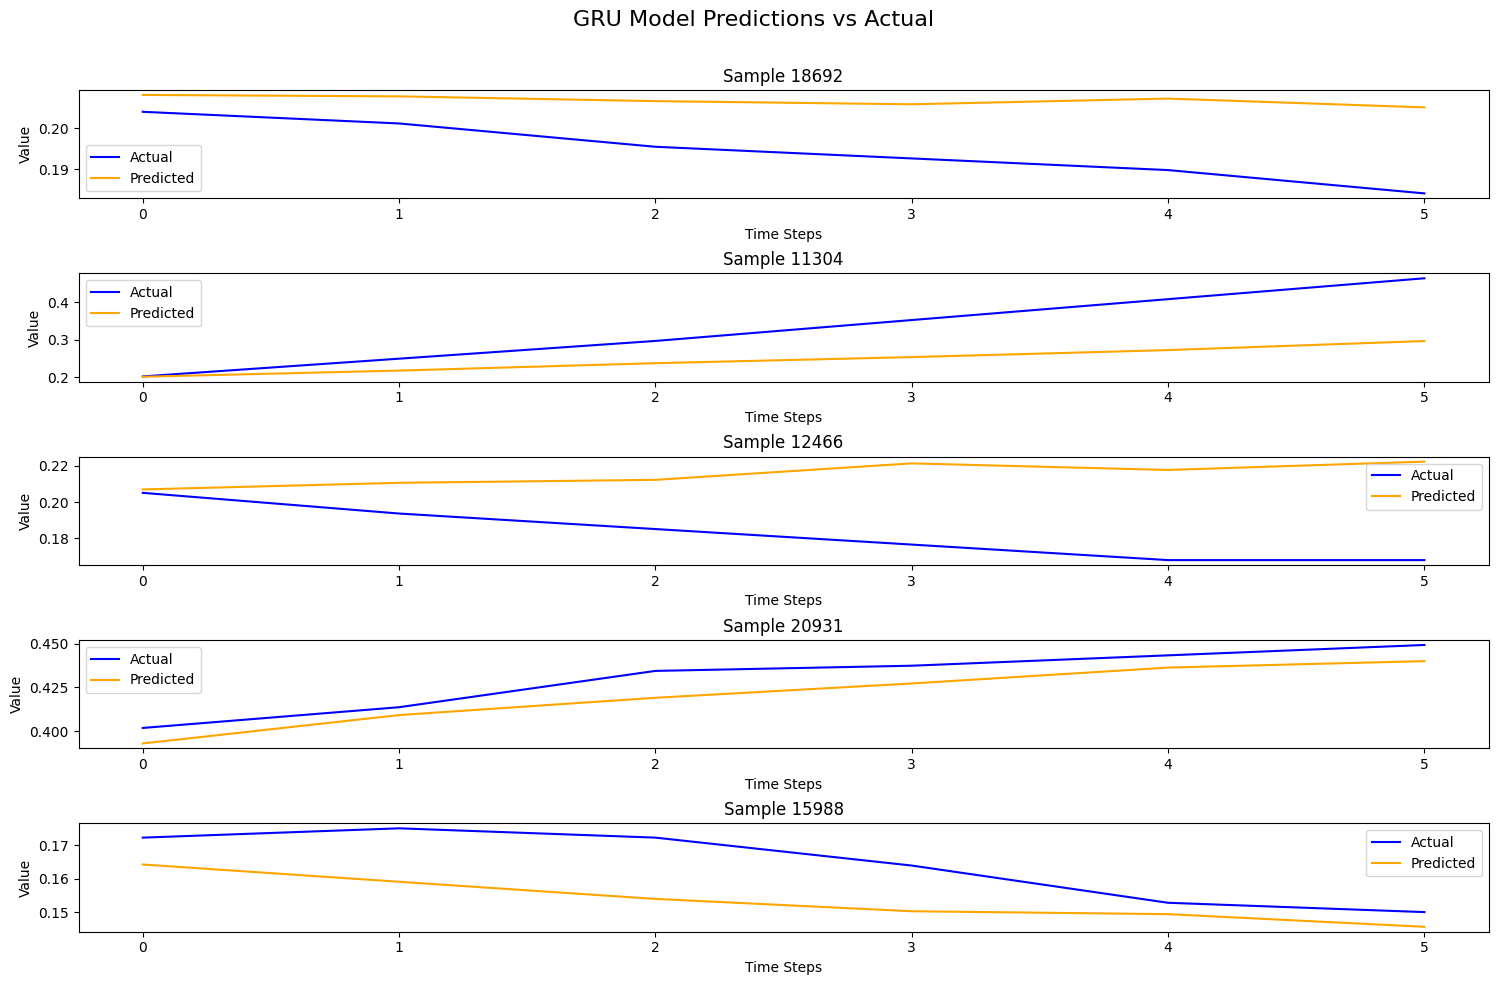

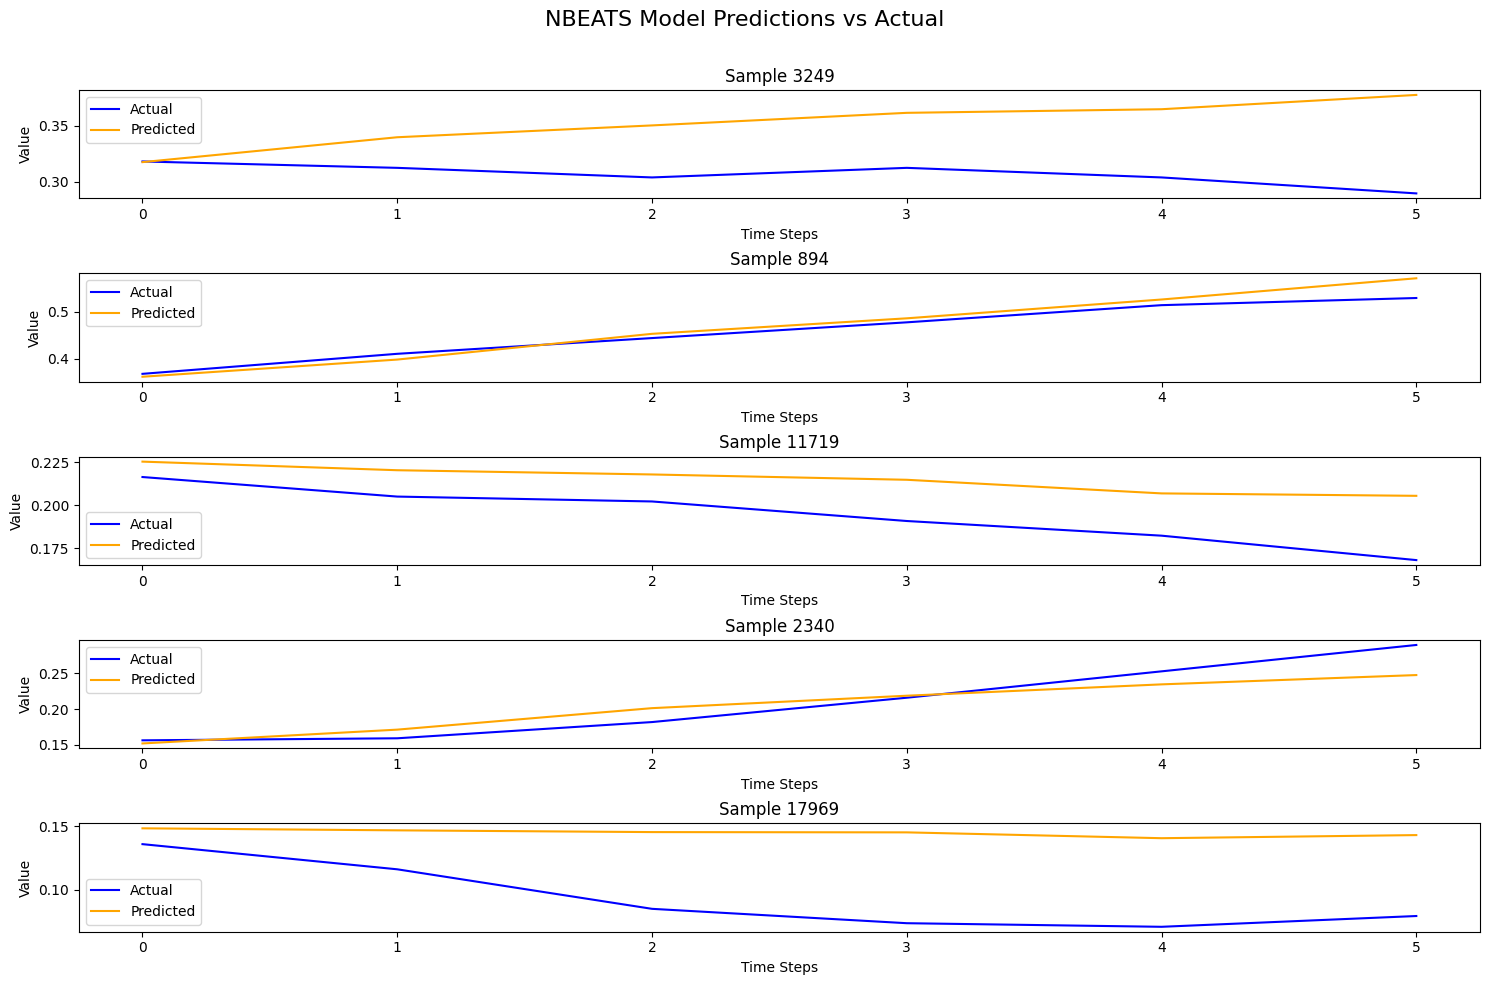

In [17]:
print("TESTTESTESTESTESTEST:", pred_all_GRU.shape, pred_all_NBEATS.shape)
pred_tf_gru = pred_all_GRU[:,:,0]
pred_tf_gru = tf.convert_to_tensor(pred_tf_gru, dtype=tf.float32)
pred_exog_gru = pred_all_GRU[:,:,1:]
pred_tf_nbeats = pred_all_NBEATS[:,:,0]
pred_tf_nbeats = tf.convert_to_tensor(pred_tf_nbeats, dtype=tf.float32)
pred_exog_nbeats = pred_all_NBEATS[:,:,1:]
#pred_tf_tft = pred_all_TFT[:,:,0]
#pred_tf_tft = tf.convert_to_tensor(pred_tf_tft, dtype=tf.float32)
#pred_exog_tft = pred_all_TFT[:,:,1:]
#pred_tf_nbeatsx = pred_all_NBEATSx[:,:,0]
#pred_tf_nbeatsx = tf.convert_to_tensor(pred_tf_nbeatsx, dtype=tf.float32)
#pred_exog_nbeatsx = pred_all_NBEATSx[:,:,1:]

#print(dataset.X_test_exog.shape[0], dataset.Y_test, pred_tf)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_gru)
print(
    f"gru model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeats)
print(
    f"nbeats model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
#mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_tft)
#print(
#    f"tft model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
#)
#mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeatsx)
#print(
#    f"nbeatsx model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
#)
def plot_predictions(y_true, y_pred, name, title='Model Predictions vs Actual', num_samples=5):

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Select a random sample of indices to plot
    indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(y_true[idx], label='Actual', color='blue')
        plt.plot(y_pred[idx], label='Predicted', color='orange')
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
    plt.savefig(f"plot_predictions{name}.png")
    plt.show()

# Assuming you have your predictions and actual values
# pred_tf is the output from your model
# dataset.Y_test is the actual target values
# Reshape predictions if necessary
pred_tf_reshaped_gru = pred_tf_gru.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
pred_tf_reshaped_nbeats = pred_tf_nbeats.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
#pred_tf_reshaped_tft = pred_tf_tft.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
#pred_tf_reshaped_nbeatsx = pred_tf_nbeatsx.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()

y_test_reshaped = dataset.Y_test.reshape(-1, horizon)  # Adjust based on your target shape
print("TEST", pred_tf_reshaped_gru.shape, pred_tf_reshaped_nbeats.shape)#, pred_tf_reshaped_tft.shape, pred_tf_reshaped_nbeatsx.shape, y_test_reshaped.shape)
# Call the plotting function
plot_predictions(y_test_reshaped, pred_tf_reshaped_gru, "gru", title='GRU Model Predictions vs Actual')
plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeats, "nbeats", title='NBEATS Model Predictions vs Actual')
#plot_predictions(y_test_reshaped, pred_tf_reshaped_tft, "tft", title='TFT Model Predictions vs Actual')
#plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeatsx, "nbeatsx", title='NBEATSx Model Predictions vs Actual')

#for i in range(dataset.X_test_exog.shape[0]):
#print(pred_tf)

In [18]:
pred_all = pred_all_NBEATS
pred_tf = pred_tf_nbeats

hyper_bound, hypo_bound = 180, 70
print(f"===========CF generation setup=============")
print(f"hyper bound value: {hyper_bound}, hypo bound: {hypo_bound}.")

args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
event_labels = list()
for i in range(len(pred_tf)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original = scaler.inverse_transform(tf.reshape(pred_tf[i], (1, -1)).numpy())
    if np.any(Y_preds_original >= hyper_bound):
        event_labels.append("hyper")
    elif np.any(Y_preds_original <= hypo_bound):
        event_labels.append("hypo")
    else:
        event_labels.append("normal")
hyper_indices = np.argwhere(np.array(event_labels) == "hyper").reshape(-1)
hypo_indices = np.argwhere(np.array(event_labels) == "hypo").reshape(-1)

print(f"hyper_indices shape: {hyper_indices.shape}")
print(f"hypo_indices shape: {hypo_indices.shape}")

print("LSASLSLKDGNS", Y_preds_original)
#plot(orig_train, orig_test, Y_preds_original)

# use a subset of the test
rand_test_size = 100
print(args.test_group)
if args.test_group == "hyper":
    if len(hyper_indices) >= rand_test_size:
        print("if", hyper_indices)
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hyper_indices, rand_test_size, replace=False
        )
    else:
        print("else", hyper_indices)
        rand_test_idx = hyper_indices
elif args.test_group == "hypo":
    if len(hypo_indices) >= rand_test_size:
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hypo_indices, rand_test_size, replace=False
        )
    else:
        rand_test_idx = hypo_indices
else:
    rand_test_idx = np.arange(dataset.X_reg_exog.shape[0])

Exog_test = dataset.X_reg_exog[rand_test_idx]
Target_test = dataset.X_reg_target[rand_test_idx]

print("ET", Exog_test, Target_test)

print(
    f"Generating CFs for {len(rand_test_idx)} samples in total, for {args.test_group} test group..."
)

# loss calculation ==> min/max bounds
desired_max_lst, desired_min_lst = list(), list()
hist_inputs = list()

# define the desired center to reach in two hours (24 timesteps for OhioT1DM)
# then we need to cut the first 6 steps to generate the desired bounds
desired_steps = 24 if args.dataset == "ohiot1dm" else 20
if args.test_group == "hyper":
    desired_center_2h = hyper_bound - 10  # -10 for a fluctuating bound
elif args.test_group == "hypo":
    desired_center_2h = hypo_bound + 10  # +10 for a fluctuating bound
else:
    print(
        f"Group not identified: {args.test_group}, use a default center"
    )
    desired_center_2h = (hyper_bound + hypo_bound) / 2
#print(f"desired center {desired_center_2h} in {desired_steps} timesteps.")

for i in range(len(Exog_test)): #???Maybe join exog, target
    idx = dataset.reg_idxs[rand_test_idx[i]]
    scaler = dataset.scaler[idx]

    desired_center_scaled = scaler[TARGET_COL].transform(
        np.array(desired_center_2h).reshape(-1, 1)
    )[0][0]
    #print(
    #    f"desired_center: {desired_center_2h}; after scaling: {desired_center_scaled:0.4f}"
    #)
    # desired trend bounds: use the `center` parameter from the input sequence as the starting point
    desired_max_scaled, desired_min_scaled = generate_bounds(
        center=center,  # Use the parameters defined at the beginning of the script
        shift=desired_shift,
        desired_center=desired_center_scaled,
        poly_order=poly_order,
        horizon=horizon,
        fraction_std=fraction_std,
        input_series=np.transpose(Target_test[i,0]),
        desired_steps=desired_steps,
    )
    print("max", desired_max_scaled)
    # TODO: remove the ones that already satisfy the bounds here, OR afterwards?
    desired_max_lst.append(desired_max_scaled)
    desired_min_lst.append(desired_min_scaled)
    hist_inputs.append(dataset.historical_values[idx])
    
#for i in range(X_test.shape[0]):
#    max_bound = (
#        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
#    )
#    min_bound = (
#        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
#    )


===========CF generation setup=============
hyper bound value: 180, hypo bound: 70.
hyper_indices shape: (7410,)
hypo_indices shape: (800,)
LSASLSLKDGNS [[151.74236 149.60217 149.07474 148.10837 144.87787 145.71785]]
hyper
if [   55    56    57 ... 21020 21021 21022]
ET [[[0.         0.2625     0.         0.        ]
  [0.96428571 0.         0.         0.        ]
  [0.96428571 0.         0.         0.        ]
  [0.96428571 0.         0.         0.        ]
  [0.96428571 0.         0.         0.        ]
  [0.96428571 0.         0.         0.        ]]

 [[0.4516129  0.         0.         0.        ]
  [0.4516129  0.         0.         0.        ]
  [0.4516129  0.         0.         0.        ]
  [0.4516129  0.         0.         0.        ]
  [0.4516129  0.         0.         0.        ]
  [0.4516129  0.         0.         0.        ]]

 [[0.76923077 0.         0.         0.        ]
  [0.76923077 0.         0.         0.        ]
  [0.76923077 0.         0.         0.        ]
  [0.

In [25]:
import numpy as np
import tensorflow as tf
import statsmodels.api as sm

class TimeSeriesOptimizer:
    def __init__(self, method, dataset, pred_exog, desired_max_lst, desired_min_lst, pred_tf, rand_test_idx, horizon, target_col):
        self.method = method  # 'sarimax', 'ols', 'gru', or 'nbeats'
        self.dataset = dataset
        self.pred_exog = pred_exog
        self.desired_max_lst = desired_max_lst
        self.desired_min_lst = desired_min_lst
        self.pred_tf = pred_tf
        self.rand_test_idx = rand_test_idx
        self.horizon = horizon
        self.TARGET_COL = target_col

        # placeholders for results
        self.targets = None
        self.orig_targets = None
        self.exogs = None
        self.losses = None

        # initialize model object based on method
        self.model = None
        self.optimizer = None

        self._init_method()

    def _init_method(self):
        if self.method == 'sarimax':
            # No pretraining here, SARIMAX models trained per sample
            pass
        elif self.method == 'ols':
            # Similarly, OLS models trained per sample
            pass
        elif self.method == 'gru':
            self._init_gru_model()
        elif self.method == 'nbeats':
            self._init_nbeats_model()
        else:
            raise ValueError(f"Unknown method: {self.method}")

    def _init_gru_model(self):
        X = self.dataset.X_reg_exog
        y = self.dataset.X_reg_target[:, self.TARGET_COL]
        X_val = self.dataset.X_reg_val_exog
        y_val = self.dataset.X_reg_val_target[:, self.TARGET_COL]

        in_features = X.shape[2]
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.horizon, in_features)),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=True),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=False),
            tf.keras.layers.Dense(self.horizon, activation='linear'),
            tf.keras.layers.Reshape((self.horizon, 1))
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.model.compile(optimizer=self.optimizer, loss='mae')
        self.model.fit(X, y, epochs=200, batch_size=64,
                       validation_data=(X_val, y_val),
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    def _init_nbeats_model(self):
        back_horizon = self.horizon  # adapt if different
        n_features = self.dataset.X_reg_exog.shape[2]

        class NBeatsBlock(tf.keras.layers.Layer):
            def __init__(self, units, horizon):
                super().__init__()
                self.fc1 = tf.keras.layers.Dense(units, activation='relu')
                self.fc2 = tf.keras.layers.Dense(units, activation='relu')
                self.fc3 = tf.keras.layers.Dense(units, activation='relu')
                self.fc4 = tf.keras.layers.Dense(units, activation='relu')
                self.forecast = tf.keras.layers.Dense(horizon)

            def call(self, inputs):
                x = self.fc1(inputs)
                x = self.fc2(x)
                x = self.fc3(x)
                x = self.fc4(x)
                return self.forecast(x)

        class DifferentiableNBeats(tf.keras.Model):
            def __init__(self, units=128):
                super().__init__()
                self.flatten = tf.keras.layers.Flatten()
                self.block = NBeatsBlock(units, self.horizon)

            def call(self, x):
                x = self.flatten(x)
                return self.block(x)

        self.model = DifferentiableNBeats()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(optimizer=self.optimizer, loss='mae')

        # Optionally fit here if you have X_train, y_train, etc.

    def compute_loss(self, max_bound, min_bound, pred):
        mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
        return mse(max_bound, pred) + mse(min_bound, pred)

    def compute_gradient_finite_difference(self, model, X_e, max_bound, min_bound, epsilon=1e-4):
        # Used for SARIMAX and OLS only
        original_pred = None
        if self.method == 'sarimax':
            temp = X_e.numpy()
            pred = model.forecast(self.horizon, start_params=model.params, exog=temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred
        elif self.method == 'ols':
            temp = X_e.numpy()
            pred = model.predict(temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred

        original_loss = self.compute_loss(max_bound, min_bound, original_pred)

        gradients = np.zeros_like(X_e.numpy())
        for i in range(X_e.shape[0]):
            X_e_perturbed = X_e.numpy()
            X_e_perturbed[i] += epsilon

            if self.method == 'sarimax':
                pred_perturbed = model.forecast(self.horizon, start_params=model.params, exog=X_e_perturbed)
            elif self.method == 'ols':
                pred_perturbed = model.predict(X_e_perturbed)
            pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)

            perturbed_loss = self.compute_loss(max_bound, min_bound, pred_perturbed)
            gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon

        return gradients

    def optimize(self):
        length = len(self.desired_max_lst)
        self.targets = np.empty((length, self.horizon))
        self.orig_targets = np.empty((length, self.horizon))
        self.exogs = np.empty_like(self.pred_exog)
        self.losses = np.empty(length)

        for i in range(length):
            max_bound = self.desired_max_lst[i]
            min_bound = self.desired_min_lst[i]

            if self.method == 'sarimax':
                self._optimize_sarimax(i, max_bound, min_bound)
            elif self.method == 'ols':
                self._optimize_ols(i, max_bound, min_bound)
            elif self.method == 'gru':
                self._optimize_gru(i, max_bound, min_bound)
            elif self.method == 'nbeats':
                self._optimize_nbeats(i, max_bound, min_bound)
            else:
                raise ValueError(f"Unknown method: {self.method}")

    def _optimize_sarimax(self, i, max_bound, min_bound):
        # Extract exog and target
        X = self.dataset.X_reg_exog[i]
        y = self.dataset.X_reg_target[i][:, self.TARGET_COL]

        mod = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1, 0, 0))
        mod = mod.fit(disp=False)

        start_params = mod.params
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

        grad_X_e = tf.Variable(self.pred_exog[self.rand_test_idx][i], dtype=tf.float32)

        pred = mod.forecast(self.horizon, start_params=start_params, exog=grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

        it = 0
        max_iter = 100
        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            gradients = self.compute_gradient_finite_difference(mod, grad_X_e, max_bound, min_bound)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])

            pred = mod.forecast(self.horizon, start_params=start_params, exog=grad_X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)

            it += 1

        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        Y_preds_original = scaler.inverse_transform(pred.numpy().reshape(-1, 1))

        self.targets[i] = pred.numpy()
        self.orig_targets[i] = Y_preds_original.squeeze()
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = self.compute_loss(max_bound, min_bound, pred).numpy()

    def _optimize_ols(self, i, max_bound, min_bound):
        X = self.dataset.X_reg_exog[i]
        y = self.dataset.X_reg_target[i][:, self.TARGET_COL]

        model = sm.OLS(y, X).fit()
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

        grad_X_e = tf.Variable(self.pred_exog[self.rand_test_idx][i], dtype=tf.float32)

        pred = model.predict(grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

        it = 0
        max_iter = 100

        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            gradients = self.compute_gradient_finite_difference(model, grad_X_e, max_bound, min_bound)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])

            pred = model.predict(grad_X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)

            it += 1

        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        Y_preds_original = scaler.inverse_transform(pred.numpy().reshape(-1, 1))

        self.targets[i] = pred.numpy()
        self.orig_targets[i] = Y_preds_original.squeeze()
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = self.compute_loss(max_bound, min_bound, pred).numpy()

    def _optimize_gru(self, i, max_bound, min_bound):
        grad_X_e = tf.Variable(self.pred_exog[i], dtype=tf.float32)  # shape should be (horizon, n_features)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
    
        it = 0
        max_iter = 100
    
        pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]  # (1, horizon, 1) -> (horizon,)
        loss = self.compute_loss(max_bound, min_bound, pred)
    
        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            with tf.GradientTape() as tape:
                pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]
                loss = self.compute_loss(max_bound, min_bound, pred)
    
            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])
    
            it += 1
    
        self.targets[i] = pred.numpy()
        self.orig_targets[i] = self.pred_tf[i]
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = loss.numpy()


    def _optimize_nbeats(self, i, max_bound, min_bound):
        grad_X_e = tf.Variable(self.pred_exog[self.rand_test_idx][i], dtype=tf.float32)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

        it = 0
        max_iter = 100

        pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0]
        loss = self.compute_loss(max_bound, min_bound, pred)

        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            with tf.GradientTape() as tape:
                pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0]
                loss = self.compute_loss(max_bound, min_bound, pred)

            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])

            it += 1

        self.targets[i] = pred.numpy()
        self.orig_targets[i] = self.pred_tf[i]
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = loss.numpy()


In [26]:
pred_exog = pred_exog_nbeats
opt = TimeSeriesOptimizer(method='gru', dataset=dataset, pred_exog=pred_exog, desired_max_lst=desired_max_lst, desired_min_lst=desired_min_lst, pred_tf=pred_tf, rand_test_idx=idx, horizon=horizon, target_col=TARGET_COL)
opt.optimize()


Epoch 1/200


2025-07-01 12:28:19.195597: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


352/353 [============================>.] - ETA: 0s - loss: 0.1530

2025-07-01 12:28:45.721172: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


353/353 [==============================] - 33s 55ms/step - loss: 0.1530 - val_loss: 0.1388
Epoch 2/200
353/353 [==============================] - 14s 40ms/step - loss: 0.1376 - val_loss: 0.1369
Epoch 3/200
353/353 [==============================] - 16s 45ms/step - loss: 0.1369 - val_loss: 0.1366
Epoch 4/200
353/353 [==============================] - 15s 43ms/step - loss: 0.1367 - val_loss: 0.1366
Epoch 5/200
353/353 [==============================] - 15s 41ms/step - loss: 0.1367 - val_loss: 0.1364
Epoch 6/200
353/353 [==============================] - 15s 42ms/step - loss: 0.1366 - val_loss: 0.1363
Epoch 7/200
353/353 [==============================] - 14s 41ms/step - loss: 0.1366 - val_loss: 0.1363
Epoch 8/200
353/353 [==============================] - 14s 40ms/step - loss: 0.1365 - val_loss: 0.1367
Epoch 9/200
353/353 [==============================] - 14s 40ms/step - loss: 0.1366 - val_loss: 0.1362
Epoch 10/200
353/353 [==============================] - 14s 41ms/step - loss: 0.1364 

In [29]:
print(opt.targets)
print(opt.orig_targets)
print(opt.targets.shape)

[[0.29053897 0.29549745 0.29067424 0.29592174 0.29442173 0.29905462]
 [0.32553825 0.33283788 0.32776594 0.33609682 0.33324802 0.33599028]
 [0.36980328 0.3785671  0.3723824  0.38189459 0.38153979 0.37597027]
 [0.47248939 0.47287142 0.47288084 0.47926956 0.48790503 0.46515492]
 [0.32210425 0.33370149 0.32304451 0.32879588 0.33511618 0.33277401]
 [0.40876895 0.419296   0.40862456 0.41522482 0.42968327 0.41717333]
 [0.46758375 0.4710491  0.46966982 0.47796926 0.4862664  0.46377626]
 [0.51920646 0.51151496 0.52878857 0.52850336 0.52944142 0.51040858]
 [0.40705511 0.41545931 0.40868989 0.4180178  0.42296281 0.40826124]
 [0.61854225 0.59290993 0.61526096 0.61073256 0.62488145 0.58970362]
 [0.30539048 0.31633881 0.30598903 0.3127481  0.31470671 0.31454614]
 [0.30323482 0.31373864 0.30375621 0.31048879 0.31192559 0.31224939]
 [0.54670364 0.53599262 0.54890072 0.55039728 0.55934304 0.53152514]
 [0.41136697 0.42127857 0.41111091 0.4203659  0.43141994 0.41394377]
 [0.11029575 0.10784891 0.11074059

In [42]:
import numpy as np

def analyse_changes(old_array, new_array):
    old_array = np.array(old_array)
    new_array = np.array(new_array)

    if old_array.shape != new_array.shape:
        raise ValueError("Arrays must be the same shape")

    diff = new_array - old_array
    abs_diff = np.abs(diff)

    avg_change = np.mean(abs_diff)
    fraction_changed = np.mean(old_array != new_array)
    drasticity_std = np.std(diff)
    drasticity_range = np.ptp(diff)  # max - min

    return {
        "average_change": avg_change,
        "fraction_changed": fraction_changed,
        "drasticity_std_dev": drasticity_std,
        "drasticity_range": drasticity_range
    }

def analyse_fit_within_bounds(array, lower_bound, upper_bound):
    array = np.array(array)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)

    if not (array.shape == lower_bound.shape == upper_bound.shape):
        raise ValueError("All arrays must be the same shape")

    within_bounds = (array >= lower_bound) & (array <= upper_bound)
    fraction_within_bounds = np.mean(within_bounds)

    return {
        "fraction_within_bounds": fraction_within_bounds,
        "total_violations": np.size(array) - np.sum(within_bounds),
        "violated_indices": np.where(~within_bounds)
    }


print(opt.targets.shape, np.array(desired_min_lst).shape, np.array(desired_max_lst).shape)
#desired_min_lst = np.array(desired_min_lst).squeeze(-1)
#desired_min_lst = np.array(desired_max_lst).squeeze(-1)
change_stats = analyse_changes(opt.orig_targets, opt.targets)
fit_stats = analyse_fit_within_bounds(opt.targets, desired_min_lst, desired_max_lst)

print("Change Stats:", change_stats)
print("Fit Stats:", fit_stats)


(100, 6) (100, 6) (100, 6)
Change Stats: {'average_change': 0.20453835362568498, 'fraction_changed': 1.0, 'drasticity_std_dev': 0.20377582063907276, 'drasticity_range': 1.1774748414754868}
Fit Stats: {'fraction_within_bounds': 0.515, 'total_violations': 291, 'violated_indices': (array([ 0,  0,  0,  0,  2,  3,  3,  5,  5,  6,  6,  7,  7,  7,  8,  8,  9,
        9,  9, 10, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 16, 16, 16, 17, 17, 17, 17, 17, 19, 19, 19, 19, 19, 20, 20, 20,
       20, 21, 22, 22, 23, 23, 24, 24, 24, 25, 25, 26, 27, 27, 27, 27, 28,
       28, 28, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 33, 33, 34,
       34, 34, 34, 34, 34, 35, 35, 35, 37, 37, 38, 38, 39, 39, 39, 39, 40,
       40, 40, 40, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 43, 43,
       44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46,
       47, 47, 47, 48, 50, 50, 51, 51, 51, 51, 51, 51, 52, 53, 53, 53, 53,
       53, 53, 54, 55, 55, 55, 56, 56, 57, 57

/tmp/ipykernel_246565/1380431611.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=change_labels, y=change_values, ax=axs[0], palette='Blues_r')
/tmp/ipykernel_246565/1380431611.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(change_labels, rotation=15)
/tmp/ipykernel_246565/1380431611.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=fit_labels, y=fit_values, ax=axs[1], palette='Greens_r')
/tmp/ipykernel_246565/1380431611.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


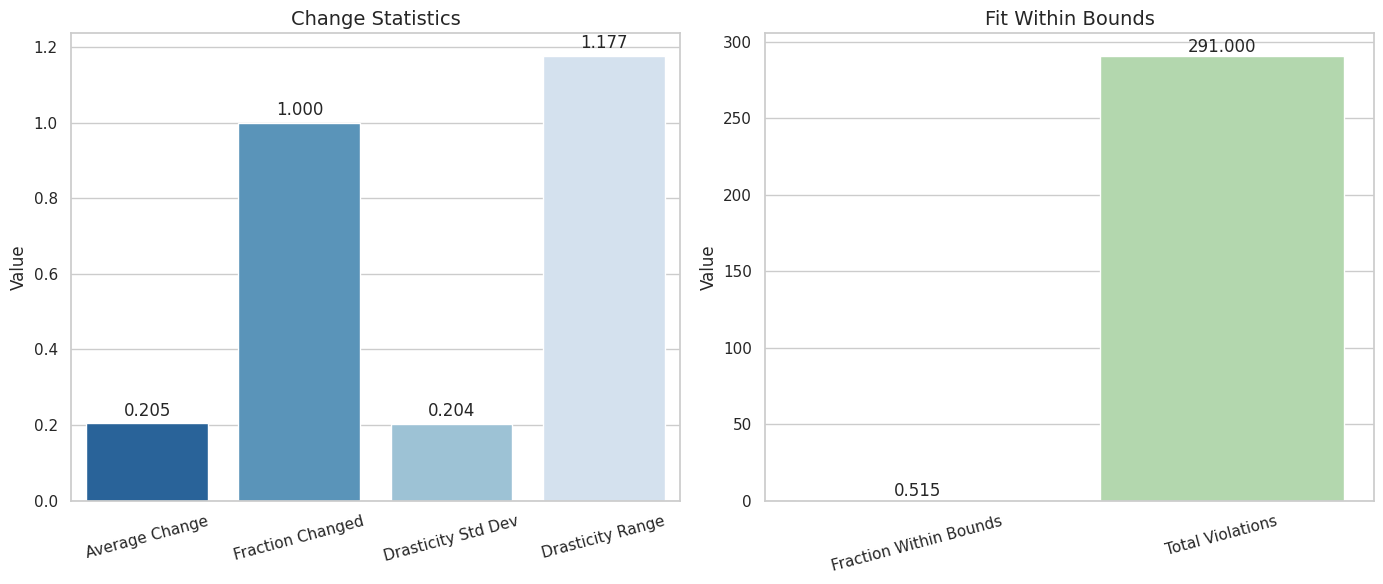

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_stats(change_stats, fit_stats):
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ---- Plot 1: Change Stats ----
    change_labels = [
        'Average Change',
        'Fraction Changed',
        'Drasticity Std Dev',
        'Drasticity Range'
    ]
    change_values = [
        change_stats['average_change'],
        change_stats['fraction_changed'],
        change_stats['drasticity_std_dev'],
        change_stats['drasticity_range']
    ]

    bars = sns.barplot(x=change_labels, y=change_values, ax=axs[0], palette='Blues_r')
    axs[0].set_title("Change Statistics", fontsize=14)
    axs[0].set_ylabel("Value")
    axs[0].set_xticklabels(change_labels, rotation=15)

    for bar, val in zip(bars.patches, change_values):
        height = bar.get_height()
        axs[0].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{val:.3f}", ha='center', va='bottom')

    # ---- Plot 2: Fit Stats ----
    fit_labels = ['Fraction Within Bounds', 'Total Violations']
    fit_values = [
        fit_stats['fraction_within_bounds'],
        fit_stats['total_violations']
    ]

    bars = sns.barplot(x=fit_labels, y=fit_values, ax=axs[1], palette='Greens_r')
    axs[1].set_title("Fit Within Bounds", fontsize=14)
    axs[1].set_ylabel("Value")
    axs[1].set_xticklabels(fit_labels, rotation=15)

    for bar, val in zip(bars.patches, fit_values):
        height = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{val:.3f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


change_stats = analyse_changes(opt.orig_targets, opt.targets)
fit_stats = analyse_fit_within_bounds(opt.targets, desired_min_lst, desired_max_lst)

plot_stats(change_stats, fit_stats)


/tmp/ipykernel_246565/3917538550.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(mean_per_feature_change)), y=mean_per_feature_change, ax=axs[1, 0], palette="coolwarm")


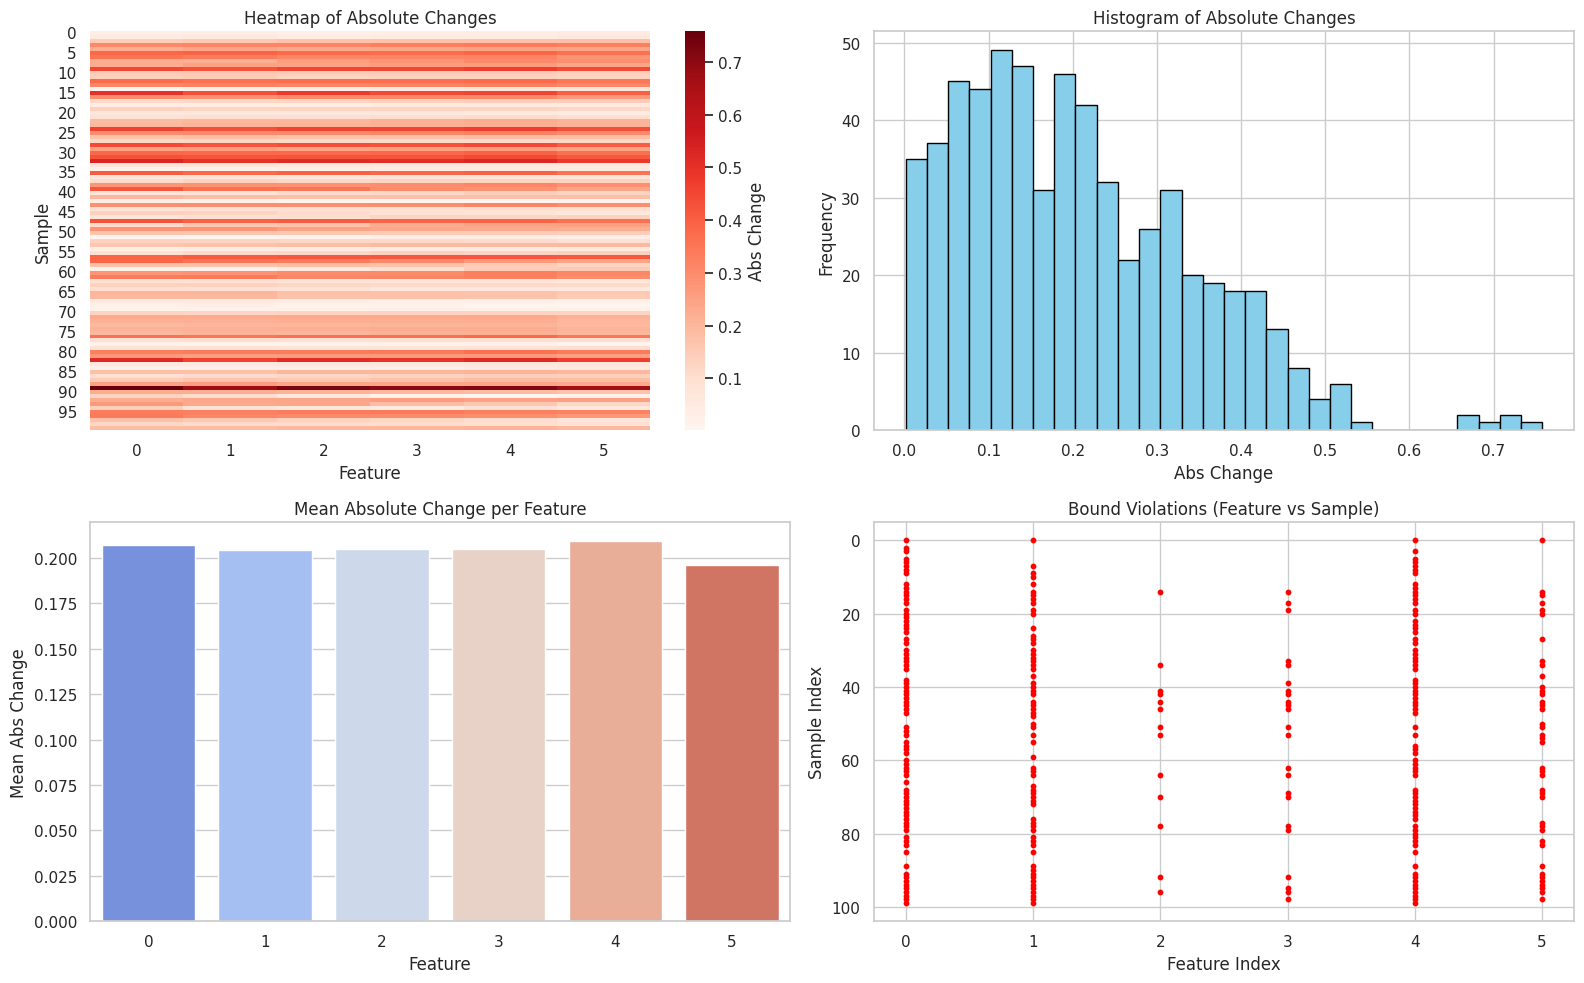

In [47]:
def plot_detailed_stats(old_array, new_array, lower_bound, upper_bound):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    old_array = np.array(old_array)
    new_array = np.array(new_array)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)

    diff = new_array - old_array
    abs_diff = np.abs(diff)
    within_bounds = (new_array >= lower_bound) & (new_array <= upper_bound)
    violations = ~within_bounds

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    sns.set(style="whitegrid")

    # 1. Heatmap of absolute changes
    sns.heatmap(abs_diff, ax=axs[0, 0], cmap="Reds", cbar_kws={'label': 'Abs Change'})
    axs[0, 0].set_title("Heatmap of Absolute Changes")
    axs[0, 0].set_xlabel("Feature")
    axs[0, 0].set_ylabel("Sample")

    # 2. Histogram of absolute changes
    axs[0, 1].hist(abs_diff.flatten(), bins=30, color='skyblue', edgecolor='black')
    axs[0, 1].set_title("Histogram of Absolute Changes")
    axs[0, 1].set_xlabel("Abs Change")
    axs[0, 1].set_ylabel("Frequency")

    # 3. Bar plot of per-feature average change
    mean_per_feature_change = abs_diff.mean(axis=0)
    sns.barplot(x=np.arange(len(mean_per_feature_change)), y=mean_per_feature_change, ax=axs[1, 0], palette="coolwarm")
    axs[1, 0].set_title("Mean Absolute Change per Feature")
    axs[1, 0].set_xlabel("Feature")
    axs[1, 0].set_ylabel("Mean Abs Change")

    # 4. Scatter plot of violations
    violation_indices = np.argwhere(violations)
    axs[1, 1].scatter(violation_indices[:, 1], violation_indices[:, 0], c='red', s=10)
    axs[1, 1].set_title("Bound Violations (Feature vs Sample)")
    axs[1, 1].set_xlabel("Feature Index")
    axs[1, 1].set_ylabel("Sample Index")
    axs[1, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()

plot_detailed_stats(opt.orig_targets, opt.targets, desired_min_lst, desired_max_lst)


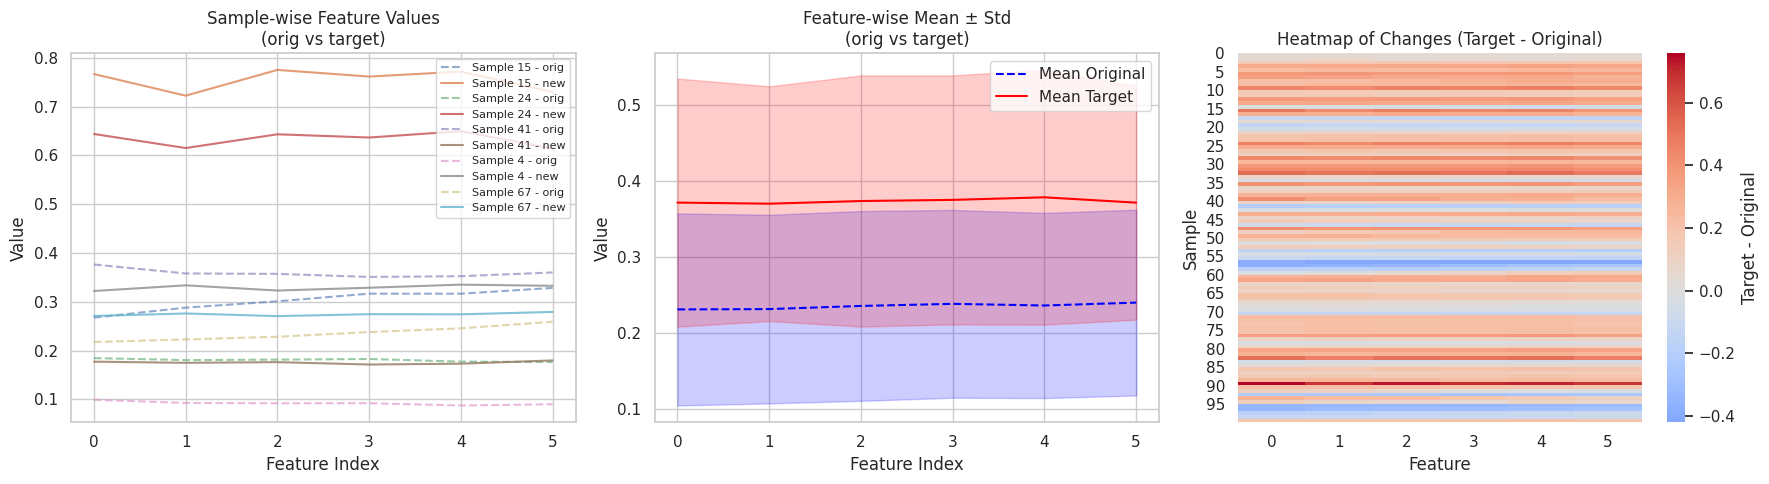

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_orig_vs_target(orig_targets, targets, num_samples_to_plot=5):
    orig = np.array(orig_targets)
    new = np.array(targets)
    
    if orig.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")
    
    num_samples, num_features = orig.shape

    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Line plot for a few random samples
    sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
    for idx in sample_indices:
        axs[0].plot(orig[idx], label=f'Sample {idx} - orig', linestyle='--', alpha=0.6)
        axs[0].plot(new[idx], label=f'Sample {idx} - new', linestyle='-', alpha=0.8)
    
    axs[0].set_title("Sample-wise Feature Values\n(orig vs target)")
    axs[0].set_xlabel("Feature Index")
    axs[0].set_ylabel("Value")
    axs[0].legend(fontsize=8)

    # 2. Overlay plot for all samples (mean and std bands)
    mean_orig = orig.mean(axis=0)
    mean_new = new.mean(axis=0)

    axs[1].plot(mean_orig, label="Mean Original", linestyle='--', color='blue')
    axs[1].plot(mean_new, label="Mean Target", linestyle='-', color='red')

    axs[1].fill_between(
        np.arange(num_features),
        mean_orig - orig.std(axis=0),
        mean_orig + orig.std(axis=0),
        color='blue', alpha=0.2
    )
    axs[1].fill_between(
        np.arange(num_features),
        mean_new - new.std(axis=0),
        mean_new + new.std(axis=0),
        color='red', alpha=0.2
    )

    axs[1].set_title("Feature-wise Mean ± Std\n(orig vs target)")
    axs[1].set_xlabel("Feature Index")
    axs[1].set_ylabel("Value")
    axs[1].legend()

    # 3. Heatmap of deltas (orig - new)
    diff = new - orig
    sns.heatmap(diff, cmap="coolwarm", center=0, ax=axs[2], cbar_kws={'label': 'Target - Original'})
    axs[2].set_title("Heatmap of Changes (Target - Original)")
    axs[2].set_xlabel("Feature")
    axs[2].set_ylabel("Sample")

    plt.tight_layout()
    plt.show()



plot_orig_vs_target(opt.orig_targets, opt.targets)


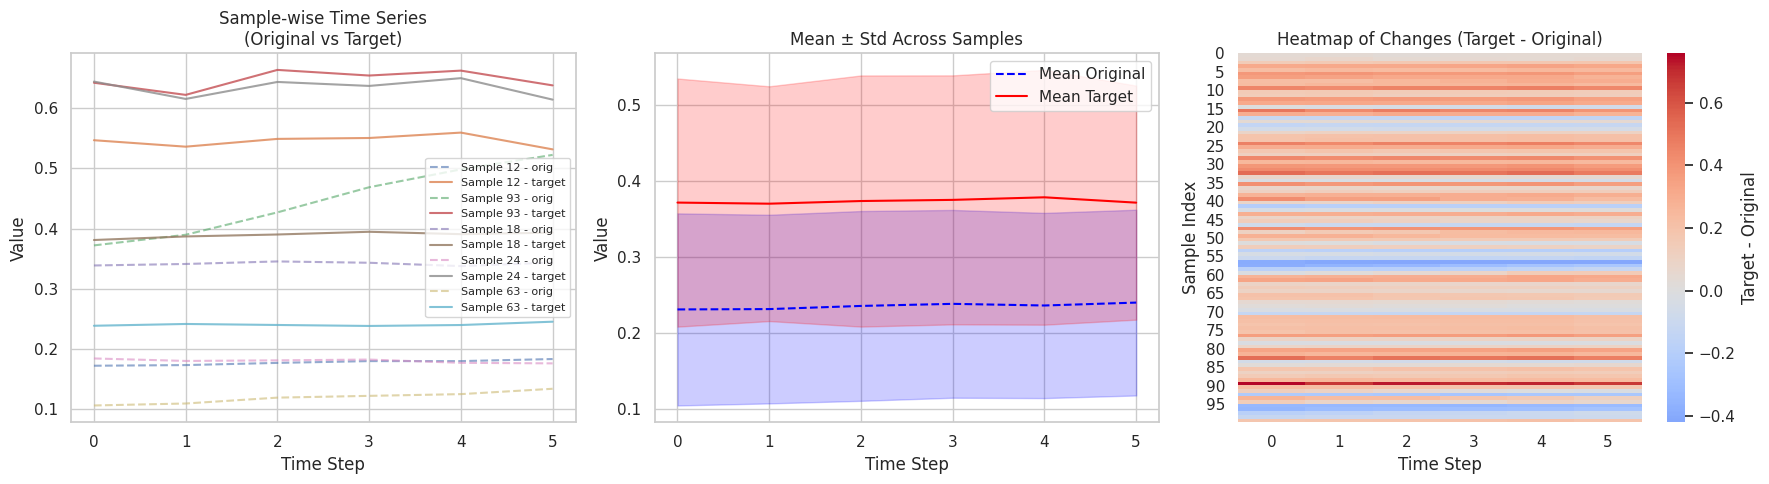

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_orig_vs_target_timeseries(orig_targets, targets, num_samples_to_plot=5):
    orig = np.array(orig_targets)
    new = np.array(targets)
    
    if orig.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")

    num_samples, num_timesteps = orig.shape

    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Time series plots for a few random samples
    sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
    for idx in sample_indices:
        axs[0].plot(orig[idx], label=f'Sample {idx} - orig', linestyle='--', alpha=0.6)
        axs[0].plot(new[idx], label=f'Sample {idx} - target', linestyle='-', alpha=0.8)

    axs[0].set_title("Sample-wise Time Series\n(Original vs Target)")
    axs[0].set_xlabel("Time Step")
    axs[0].set_ylabel("Value")
    axs[0].legend(fontsize=8)
    plt.savefig("0_gru.png")

    # 2. Mean ± std band plot across all samples
    mean_orig = orig.mean(axis=0)
    mean_new = new.mean(axis=0)
    std_orig = orig.std(axis=0)
    std_new = new.std(axis=0)

    axs[1].plot(mean_orig, label="Mean Original", linestyle='--', color='blue')
    axs[1].plot(mean_new, label="Mean Target", linestyle='-', color='red')

    axs[1].fill_between(np.arange(num_timesteps), mean_orig - std_orig, mean_orig + std_orig, color='blue', alpha=0.2)
    axs[1].fill_between(np.arange(num_timesteps), mean_new - std_new, mean_new + std_new, color='red', alpha=0.2)

    axs[1].set_title("Mean ± Std Across Samples")
    axs[1].set_xlabel("Time Step")
    axs[1].set_ylabel("Value")
    axs[1].legend()
    plt.savefig("1_gru.png")

    # 3. Heatmap of differences (target - original) per sample
    diff = new - orig
    sns.heatmap(diff, cmap="coolwarm", center=0, ax=axs[2], cbar_kws={'label': 'Target - Original'})
    axs[2].set_title("Heatmap of Changes (Target - Original)")
    axs[2].set_xlabel("Time Step")
    axs[2].set_ylabel("Sample Index")
    plt.savefig("2_gru.png")

    plt.tight_layout()
    plt.show()


plot_orig_vs_target_timeseries(opt.orig_targets, opt.targets)


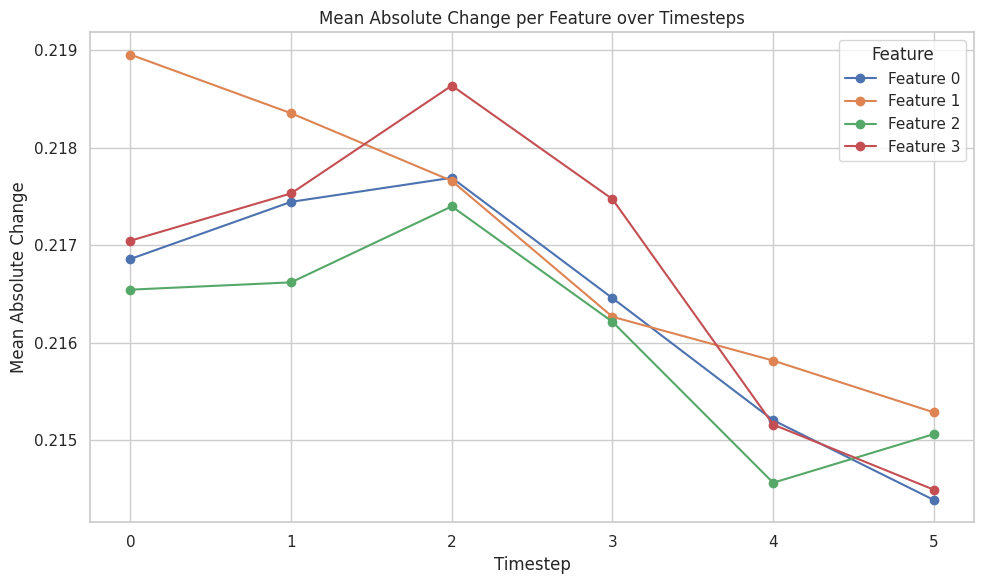

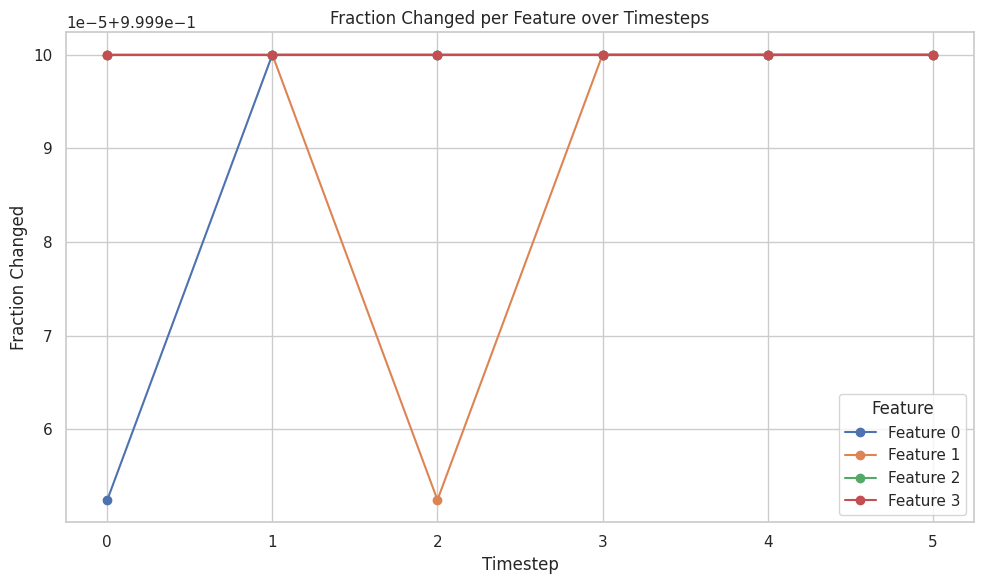

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_changes_over_time(old_array, new_array, stat='mean'):
    old = np.array(old_array)
    new = np.array(new_array)

    if old.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")

    abs_diff = np.abs(new - old)  # shape: (samples, timesteps, features)

    if stat == 'mean':
        data = abs_diff.mean(axis=0)  # shape: (timesteps, features)
        ylabel = "Mean Absolute Change"
    elif stat == 'std':
        data = abs_diff.std(axis=0)
        ylabel = "Std Dev of Change"
    elif stat == 'fraction':
        data = (abs_diff > 1e-6).mean(axis=0)
        ylabel = "Fraction Changed"
    else:
        raise ValueError("Unsupported stat: choose from 'mean', 'std', 'fraction'")

    timesteps = np.arange(data.shape[0])
    num_features = data.shape[1]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    for i in range(num_features):
        plt.plot(timesteps, data[:, i], marker='o', label=f"Feature {i}")

    plt.title(f"{ylabel} per Feature over Timesteps")
    plt.xlabel("Timestep")
    plt.ylabel(ylabel)
    plt.xticks(timesteps)
    plt.legend(title="Feature")
    plt.tight_layout()
    plt.show()


plot_feature_changes_over_time(pred_exog, opt.exogs, stat='mean')
plot_feature_changes_over_time(pred_exog, opt.exogs, stat='fraction')
